# Import Libraries & Tools

In [1]:
import requests
import math
import re
import os
import json
from os.path import exists
from tqdm import tqdm
from scipy.stats import entropy
from itertools import product
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options

# Constants & Important Variables

In [2]:
#get path to project directory
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__"))
)

#important files & variables
PATTERN_MATRIX_FILE = os.path.join(DATA_DIR, "pattern_matrix.csv")
WORD_FREQ_MAP_FILE = os.path.join(DATA_DIR, "freq_map.json")

#243 combinations of colors (3^5) - g = green, r = gray, y = yellow
COMBINATIONS = [''.join(i) for i in product('gry', repeat = 5)]
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

## Scrape Wordle Site To Extract Word Lists

In [3]:
#scrape wordle site for javasript source
url = 'https://www.nytimes.com/games/wordle/index.html'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
js_file = soup.find_all('script', {"src":True})[0]['src']
js_url = 'https://www.nytimes.com/games/wordle/' + js_file

#javascript soup
js_r = requests.get(js_url)
js_soup = BeautifulSoup(js_r.content, 'html.parser')

#regex to find word lists
js_str = str(js_soup)
pattern = r"(?<=Ma=\[)(.*)(?=\],Oa)"  #solutions
pattern2 = r"(?<=Oa=\[)(.*)(?=\],Ra)" #accepted guesses
answers_regex = re.findall(pattern, js_str)
guesses_regex = re.findall(pattern2, js_str)

#flatten & sort "answers" list
answers_2d = [word.replace('"','').split(',') for word in answers_regex]
answers = [item for sublist in answers_2d for item in sublist]
answers = [word.upper() for word in answers]
answers.sort()

#flatten & sort "guesses" list
guesses_2d = [word.replace('"','').split(',') for word in guesses_regex]
guesses = [item for sublist in guesses_2d for item in sublist]
guesses = [word.upper() for word in guesses]
guesses = guesses + answers
guesses.sort()

NUM_GUESSES = len(guesses)
NUM_ANSWERS = len(answers)

print(f'# of Answers: {NUM_ANSWERS}')
print(f'# of Possible Guesses: {NUM_GUESSES}')

# of Answers: 2309
# of Possible Guesses: 12947


# Initial Data Analysis

In [4]:
answer_letter_counts = {}
guess_letter_counts = {}

#not sure if redundant/necessary? 
for word in answers:
    for c in word:
        if c in answer_letter_counts:
            answer_letter_counts[c] += 1
        else:
            answer_letter_counts[c] = 1

#calculates letter counts for all accepted guesses
for word in guesses:
    for c in word:
        if c in guess_letter_counts:
            guess_letter_counts[c] += 1
        else:
            guess_letter_counts[c] = 1

In [5]:
#calculates letter frequency for given letter position
def freq_count(data, pos):
    freq = {}
    
    #initialize every value to 0
    for letter in ALPHABET:
        freq[letter] = 0
    
    #calculate frequency table
    for word in data:
        word = word.upper()
        if word[pos] in freq:
            freq[word[pos]] += 1
        else:
            freq[word[pos]] = 1

    return freq

#calculate probability for each letter in each position
def letter_prob_guesses(letter):
    letter = letter.upper()

    letter1 = letter_pos_gue_counts[0][letter] / NUM_GUESSES
    letter2 = letter_pos_gue_counts[1][letter] / NUM_GUESSES
    letter3 = letter_pos_gue_counts[2][letter] / NUM_GUESSES
    letter4 = letter_pos_gue_counts[3][letter] / NUM_GUESSES
    letter5 = letter_pos_gue_counts[4][letter] / NUM_GUESSES
    
    return [letter1, letter2, letter3, letter4, letter5]

#adds text labels - might remove
def addlabels(x,y):
    plt.text(x, y, y, ha = 'center', fontsize=10)

#plot bar graph showing letter distributions for word set
def plot_letter_dist(dic, title):
    #figure details
    fig, ax = plt.subplots(1,2,figsize=(15,8))
    fig.tight_layout()
    fig.suptitle(t=f'Distribution of {title}', va='bottom', fontsize=26)
        
    #plot1
    for i in sorted(dic.items()):
        ax[0].bar(i[0], dic[i[0]])
        # addlabels(i[0], i[1])

    #plot2
    for i in sorted(dic.items(), key = lambda x: x[1], reverse = True):
        ax[1].bar(i[0], i[1])
        # addlabels(i[0], i[1])
    
    #styling
    ax[0].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    ax[1].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    plt.show()

def plot_letter_dist_both(answers, guesses, title='in Wordle'):
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    fig.suptitle(f'Letter Distributions {title}', fontsize=28)
    
    #subfigure details
    subfigs = fig.subfigures(nrows=1, ncols=2)
    subfigs[0].suptitle('Answers', fontsize = 24)
    subfigs[1].suptitle('Guesses', fontsize = 24)
    
    #loop for both plots
    for i in range(2):
        ax = subfigs[i].add_subplot(1,1,1)
        ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
        
        if i == 0: #answers
            for i in sorted(answers.items(), key = lambda x: x[1], reverse = True):
                ax.bar(i[0], i[1])
        else: #guesses
            for i in sorted(guesses.items(), key = lambda x: x[1], reverse = True):
                ax.bar(i[0], guesses[i[0]])
    
    plt.show()
    
def plot_letter_pos_dist(answers, guesses, title='for Each Position'):
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(15,14))
    fig.suptitle(f'Letter Distributions {title}', fontsize=28)
    
    titles = ['1st', '2nd', '3rd', '4th', '5th']
    
    #subfigure details
    subfigs = fig.subfigures(nrows=5, ncols=2)
    for row, subfig in enumerate(subfigs):
        subfig[0].suptitle(f'Answers - {titles[row]}', fontsize=24)
        subfig[1].suptitle(f'Guesses - {titles[row]}', fontsize=24)
    
    #loop for both plots
    for i in range(5):
        for j in range(2):
            ax = subfigs[i][j].add_subplot(1,1,1)
            ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
            if j == 0: #answers
                for k in sorted(answers[i].items(), key = lambda x: x[1], reverse = True):
                    ax.bar(k[0], k[1])
            else: #guesses
                for k in sorted(guesses[i].items(), key = lambda x: x[1], reverse = True):
                    ax.bar(k[0], guesses[i][k[0]])
    
    plt.show()

In [6]:
#dictionaries to hold letter counts for given position
letter_pos_ans_counts = {}
letter_pos_gue_counts = {}

for i in range(5):
    letter_pos_ans_counts[i] = freq_count(answers, i)
    letter_pos_gue_counts[i] = freq_count(guesses, i)

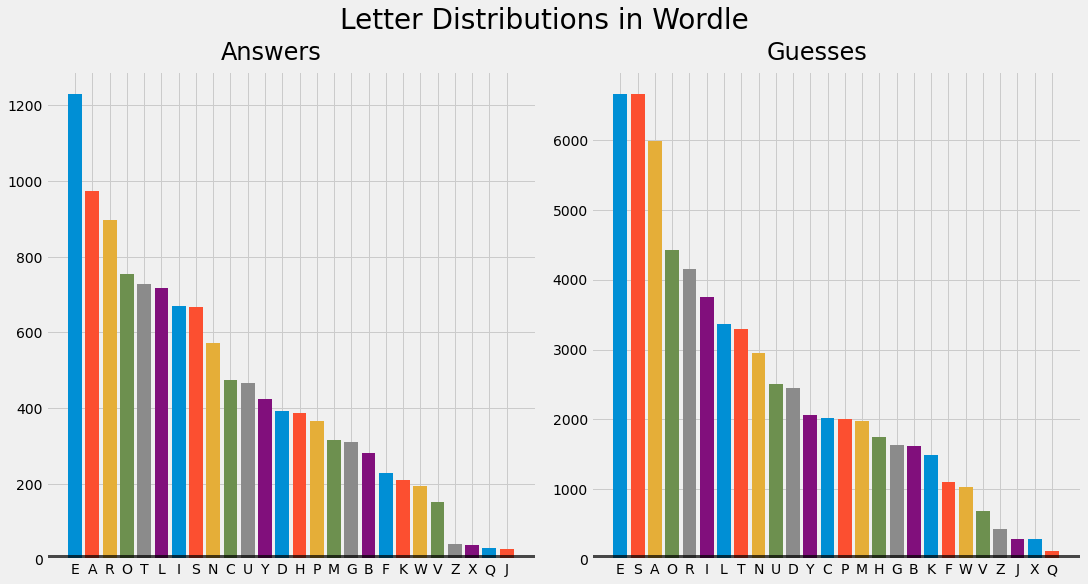

In [7]:
plot_letter_dist_both(answer_letter_counts, guess_letter_counts)

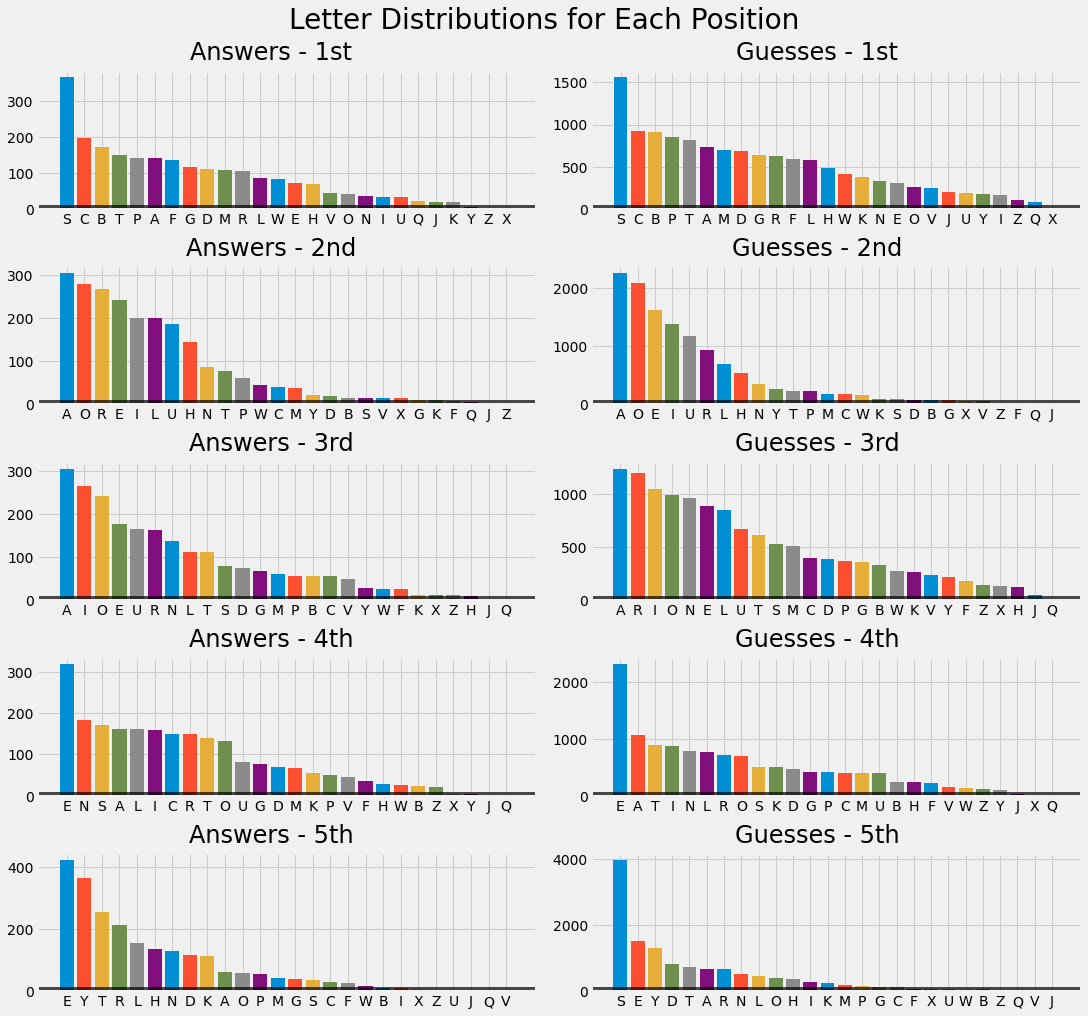

In [8]:
plot_letter_pos_dist(letter_pos_ans_counts, letter_pos_gue_counts)

# Observations

[TODO]

In [45]:
#create df of probabilities for each letter in each position
letters = pd.DataFrame(columns = ['1st', '2nd', '3rd', '4th', '5th'],
                       index=sorted(guess_letter_counts.keys()))

for i in range(26):
    probs = letter_prob_guesses(ALPHABET[i])
    for j in range(5):
        letters.iloc[i,j] = probs[j]

letters = letters.astype('float')
letters

,1st,2nd,3rd,4th,5th
A,0.056847,0.174558,0.095389,0.082876,0.052445
B,0.070132,0.006256,0.025797,0.018692,0.004557
C,0.071059,0.013594,0.030277,0.031359,0.009809
D,0.052599,0.006488,0.030123,0.036379,0.063490
E,0.023403,0.125589,0.068124,0.179424,0.117324
F,0.045957,0.001854,0.013748,0.017996,0.006334
G,0.049201,0.005793,0.027960,0.032594,0.011045
H,0.037692,0.042017,0.009269,0.018151,0.028346
I,0.012744,0.106588,0.080868,0.067969,0.021627
J,0.015602,0.000850,0.003553,0.002240,0.000232


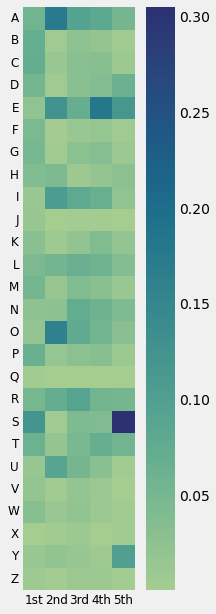

In [60]:
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.heatmap(letters, square=True, cmap='crest', cbar_kws={'shrink': 1, 'pad': 0.01})
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
plt.show()

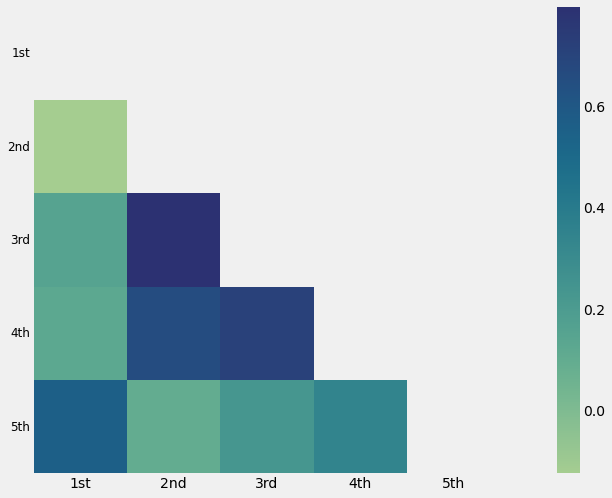

In [61]:
letter_matrix = letters.corr()
fig, ax = plt.subplots(figsize=(18,8))
mask = np.zeros_like(letter_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(letter_matrix, mask=mask, square=True, cmap='crest')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
plt.show()

# Helper Functions

In [14]:
#return list of guess words that have given letter in given position
def choices_inc(letter, pos, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if word[pos-1] == letter:
            choices.append(word)            
    return choices

#return list of guess words that contain letter NOT in given position
def choices_exc(letter, pos=0, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
    
    for word in word_bank:            
        if word[pos-1] != letter and letter in word:
            choices.append(word)   
    return choices

#return list of guess words that do NOT contain letter at all
def choices_abs_exc (letter, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if letter not in word:
            choices.append(word)    
    return choices

#calculates probability of given word and results
def get_probability(word, colors):
    word = word.upper()
    
    #list to contain lists of remaining possible matches
    pool = []
    
    #loop over each letter / color pair and compute remaining matches
    for i in range(5):
        #letter 1
        if i == 0:            
            if colors[i] == 'g': #green
                rem_set = choices_inc(word[i], i+1)
            elif colors[i] == 'r': #gray
                rem_set = choices_abs_exc(word[i])
            else: #yellow
                rem_set = choices_exc(word[i], i+1)
        
        #letters 2-5
        else:            
            if colors[i] == 'g':
                rem_set = choices_inc(word[i], i+1, pool[-1])
            elif colors[i] == 'r':
                rem_set = choices_abs_exc(word[i], pool[-1])
            else:
                rem_set = choices_exc(word[i], i+1, pool[-1])
        
        #adds remaining possible matches to pool
        if rem_set or len(rem_set) == 0:            
            pool.append(rem_set)

        # print(f'{word[i].upper()}, {colors[i]}, {len(rem_set)} matches left')
        
    num_matches = len(pool[-1])
    probability = num_matches / NUM_GUESSES
    
    #don't return an empty list
    if pool[-1] == []:
        pool[-1] = [0]        
    return probability, pool[-1]

#calculate information gain
def get_information(prob):
    if prob == 0:
        return 0.00
    return math.log2(1/prob)

#calculate entrooy of given probabilities
def get_entropy(data):    
    distributions = pd.Series(data)
    axis = len(distributions.shape) - 1
    return entropy(distributions, base=2.0, axis=axis)

#if PATTERN_MATRIX_FILE doesn't exist, create it - takes 45+ minutes!
def get_pattern_matrix(words):
    if not os.path.exists(PATTERN_MATRIX_FILE):
        all_p = {}
        for word in tqdm(words):
            all_p[word] = [get_probability(word, combo)[0] for combo in COMBINATIONS]

        #create dataframe of all probabilities
        pattern_matrix = pd.DataFrame.from_dict(all_p, orient='index', columns=COMBINATIONS).set_index('index')

        #create .csv file so we don't have to re-compute every time
        pattern_matrix.to_csv(f'pattern_matrix.csv', index=True)
        return pattern_matrix
    
    #else if PATTERN_MATRIX_FILE exists, read it in to df and return
    else:
        pattern_matrix = pd.read_csv('pattern_matrix.csv', index_col='index')
        return pattern_matrix

def plot_pattern_distr(word):
    #create temp df
    df = pd.DataFrame(columns = ['Probability'])

    #assigns probability 
    df['Probability'] = patterns.loc[word]

    #sorts highest -> lowest probability
    df.sort_values(by='Probability', ascending=False, inplace=True)
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Probability Distribution - [{word}]', fontsize=22)
    fig.tight_layout()

    #plot
    sns.barplot(x=df.index, y=df['Probability'], palette='crest')
   
    #annotations
    xloc1 = 0
    yloc1 = df.iloc[xloc1,0]
    
    #higher entropy for most common
    ax.annotate(f'Max Entropy = {round(get_entropy(patterns.loc[word]),2)}', fontsize=16,
                xy=(xloc1, yloc1), xytext=(xloc1+15, yloc1), 
                arrowprops=dict(arrowstyle='simple', facecolor='black'))
    
    #TODO - FIGURE OUT SECOND ANNOTATION - VERY INVOLVED!
#     xloc2 = 120
#     yloc2 = df.iloc[xloc2,0]
#     print(f'xloc: {xloc2}, yloc: {yloc2}')
#     print(f'df.iloc[xloc2, 0] = {df.iloc[xloc2, 0]}')
    
    
    
#     ind_calc = df[df['Probability'] == yloc2].index[0]
#     ind_p = get_probability(word, ind_calc)[0]
#     ind_i = get_information(ind_p)
    
    
#     #lower entropy for least common
#     ax.annotate(f'Entropy = {round(get_entropy(yloc2),2)}', fontsize=16,
#                 xy=(xloc2, yloc2), xytext=(xloc2-25, yloc2+0.01), 
#                 arrowprops=dict(arrowstyle='simple', facecolor='black'))

    #plot details    
    # ax.grid(visible=False)
    # ax.set_yscale('log')
    ax.set_xlim(-2,125,1)
    ax.set_xlabel(f'Patterns', fontsize=16)
    ax.set(ylabel=None)
    # ax.set_ylabel('Probability', fontsize=16)
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelsize=12)
    ax.axhline(y = -0.00025, color = 'black', linewidth = 3, alpha = .7)
    plt.show()

#removes bad words from freq_map (NYT made these changes)
#couldn't figure out how to generate the freq_map file from wolframalpha
#so I used 3b1b's!, thus I have to edit it!
def get_word_frequencies(regenerate=False):
    bad_words = ['bitch', 'chink', 'coons', 'darky', 'dyked', 'dykes', 'dykey',
                 'faggy', 'fagot', 'gooks', 'homos', 'kikes', 'lesbo', 'pussy',
                 'sluts', 'spick', 'spics', 'spiks', 'whore', 'agora', 'fibre',
                 'lynch', 'pupal', 'slave', 'wench']
    if os.path.exists(WORD_FREQ_MAP_FILE) or regenerate:
        with open(WORD_FREQ_MAP_FILE) as fp:
            result = json.load(fp)
            for word in bad_words:
                del result[word]
        return result

#implementation of a sigmoid function
def sigmoid(x):  
    z = np.exp(-x)
    sig = 1 / (1 + z)
    return sig

#gets most commonly used words based on frequency
def get_freq_based_priority(n_common=3000, width_under_sigmoid=10):
    #get frequency map
    freq_map = get_word_frequencies()
    freqs_l = np.array([w for w in freq_map.keys()])
    freqs = np.array([freq_map[w] for w in freqs_l])

    #sorts list of frequencies - but returns indexes!
    arg_sort = freqs.argsort()

    #actually sorts list, converts to list() and capitalizes each word
    sorted_words = freqs_l[arg_sort].tolist()
    sorted_words = [w.upper() for w in sorted_words]

    #"bin" width for each word
    c = width_under_sigmoid * (-0.5 + n_common / NUM_GUESSES)
    xs = np.linspace(c - width_under_sigmoid / 2, c + width_under_sigmoid / 2, NUM_GUESSES)
    
    #dict to hold words
    priorities = dict()
    
    for word, x in zip(sorted_words, xs):
        priorities[word] = sigmoid(x)
    return priorities

#get "weights" of words - not every word is used equally!
def get_weights(words, priorities):
    frequencies = np.array([priorities[word] for word in words])
    total = frequencies.sum()
    if total == 0:
        return np.zeros(frequencies.shape)
    return frequencies / total

#returns new df containing adjusted probabilities with word weights
def get_pattern_distributions(priorities):
    #get weights for each word
    weights = get_weights(guesses, priorities)

    #"blank" array same shape as `patterns`
    pattern_dist = np.zeros((NUM_GUESSES, 3**5))

    for i, prob in enumerate(weights):
        pattern_dist[i] += (patterns.iloc[i,:] + prob)
        
    #makes df to be consistent with other objects
    pattern_dist = pd.DataFrame(pattern_dist, index=guesses, columns=COMBINATIONS)    
    return pattern_dist

In [15]:
#returns dataframe of ALL probabilities for EVERY combination of EVERY word - not weighted
patterns = get_pattern_matrix(guesses)

#display 5 random samples to show it works
patterns.sample(n=5)

,ggggg,ggggr,ggggy,gggrg,gggrr,gggry,gggyg,gggyr,gggyy,ggrgg,...,yyryy,yyygg,yyygr,yyygy,yyyrg,yyyrr,yyyry,yyyyg,yyyyr,yyyyy
index,,,,,,,,,,,,,,,,,,,,,
GREGO,0.000077,0.000077,0.0,0.000000,0.000000,0.000000,0.000077,0.001081,0.0,0.000000,...,0.001004,0.000077,0.001622,0.000232,0.000000,0.000000,0.000000,0.000077,0.003476,0.000618
CRATE,0.000077,0.000000,0.0,0.000541,0.001390,0.000000,0.000000,0.000077,0.0,0.000000,...,0.000232,0.000000,0.000000,0.000077,0.000386,0.002935,0.001390,0.000000,0.000309,0.000000
SCEAT,0.000077,0.000000,0.0,0.000077,0.000154,0.000000,0.000000,0.000077,0.0,0.000077,...,0.001159,0.000000,0.000077,0.000000,0.000154,0.006102,0.001081,0.000000,0.001776,0.000309
HALON,0.000077,0.000077,0.0,0.000000,0.001159,0.000000,0.000000,0.000077,0.0,0.000000,...,0.000232,0.000000,0.000000,0.000000,0.000000,0.002781,0.000000,0.000077,0.000695,0.000000
STOAI,0.000077,0.000232,0.0,0.000000,0.002858,0.000154,0.000000,0.000077,0.0,0.000000,...,0.002549,0.000000,0.000850,0.000077,0.000154,0.010813,0.002085,0.000000,0.002240,0.000077


Probability of guessing [SLATE] w/ [grryg] pattern = 0.0015
Information Gained in Bits = 9.41
Max Entropy - [SLATE] = 5.872430217496487


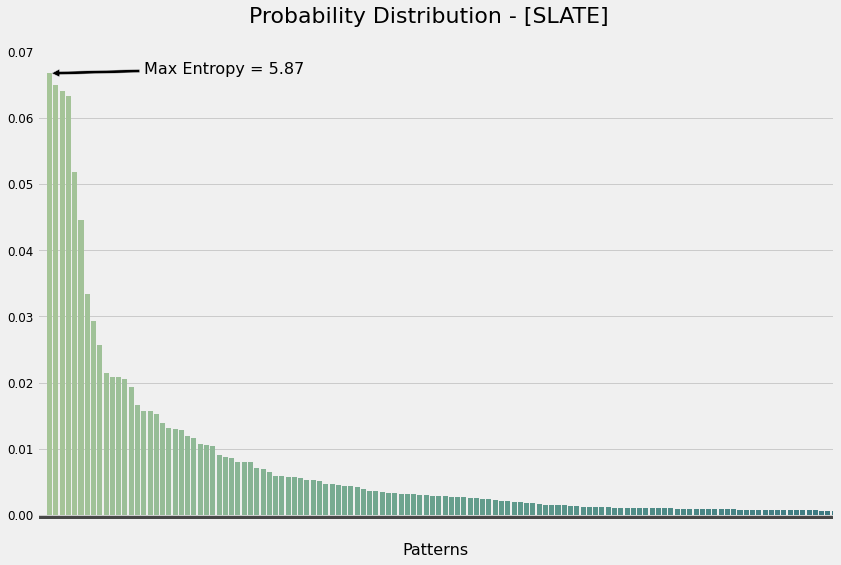

In [16]:
#testing functionality
find_word = 'SLATE'
find_patt = 'grryg'

#finds probability of given word with given pattern
p = patterns.loc[find_word, find_patt]
print(f'Probability of guessing [{find_word}] w/ [{find_patt}] pattern = {round(p,4)}')

#calculates information gain in bits
i = get_information(p)
print(f"Information Gained in Bits = {round(i,2)}")

# #print # of matches
# print(f'{len(matches)} possible matches')

#calculate entropy
print(f'Max Entropy - [{find_word}] = {get_entropy(patterns.loc[find_word])}')

#plot probability distribution
plot_pattern_distr(find_word)

In [17]:
#gets ordered dictionary of word frequency (least used -> most used)
priorities = get_freq_based_priority()

#gets distributions of patterns using newly adjusted probabilities
weighted_patterns = get_pattern_distributions(priorities)

#display 5 random samples to show it works
weighted_patterns.sample(n=5)

,ggggg,ggggr,ggggy,gggrg,gggrr,gggry,gggyg,gggyr,gggyy,ggrgg,...,yyryy,yyygg,yyygr,yyygy,yyyrg,yyyrr,yyyry,yyyyg,yyyyr,yyyyy
POSHO,0.000079,0.000002,0.000002,0.000002,0.000002,0.000543,0.000002,0.000002,0.000002,0.000002,...,0.000543,0.000002,0.000002,0.000156,0.000234,0.000002,0.005563,0.000002,0.000002,0.000465
RAVES,0.000154,0.000463,0.000077,0.000077,0.000154,0.000077,0.000077,0.000077,0.000077,0.000926,...,0.002625,0.000077,0.000077,0.000077,0.000231,0.000926,0.000077,0.000154,0.000695,0.000077
DREER,0.000087,0.000009,0.000164,0.000009,0.000009,0.000009,0.000087,0.000009,0.000782,0.000009,...,0.000009,0.002249,0.000009,0.005957,0.000009,0.000009,0.000009,0.000087,0.000009,0.003794
LIGNE,0.000145,0.000067,0.000067,0.000145,0.000145,0.000145,0.000067,0.000145,0.000067,0.000145,...,0.000994,0.000067,0.000531,0.000067,0.000454,0.001767,0.000299,0.000067,0.000145,0.000067
DICHT,0.000084,0.000007,0.000007,0.000084,0.000470,0.000238,0.000007,0.000007,0.000007,0.000084,...,0.000161,0.000007,0.000007,0.000007,0.000084,0.001783,0.000007,0.000007,0.000238,0.000007


In [18]:
# from heapq import nlargest

# largest = nlargest(50, priorities, key = priorities.get)
# text = ''
# for key in largest:
    # text += key + ' '
    # print(f'{key}: {priorities[key]}')
    # print(key)
# text = text.rstrip()